In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from scipy.sparse import linalg as LA
import qib
import matplotlib.pyplot as plt
import rqcopt as oc
import scipy
import scipy.sparse as sp
from qiskit.circuit.library import CXGate, CYGate, CZGate
from qiskit import Aer, execute, transpile
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.converters import circuit_to_dag

import sys
sys.path.append("../../src/qetu")
from qetu import qetu_rqc_oneLayer


X = np.array([[ 0.,  1.], [ 1.,  0.]])
Y = np.array([[ 0., -1j], [ 1j,  0.]])
Z = np.array([[ 1.,  0.], [ 0., -1.]])
I = np.identity(2)


def construct_heisenberg_local_term(J, h, ndims=1):
    return (  J[0]*np.kron(X, X)
            + J[1]*np.kron(Y, Y)
            + J[2]*np.kron(Z, Z)
            + h[0]*(0.5/ndims)*(np.kron(X, I) + np.kron(I, X))
            + h[1]*(0.5/ndims)*(np.kron(Y, I) + np.kron(I, Y))
            + h[2]*(0.5/ndims)*(np.kron(Z, I) + np.kron(I, Z)))

/tmp/ipykernel_10201/1964218335.py:12: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer.noise import NoiseModel, errors


In [17]:
def uncompr_trotterized_time_evolution(qc, hlocs, t, gate_b, gate_a, lamb=None):
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set
    
    K_layer_b = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer_b[perms[0][2*j]] = gate_b
        K_layer_b[perms[0][2*j+1]] = None
    K_layer_a = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer_a[perms[0][2*j]] = gate_a
        K_layer_a[perms[0][2*j+1]] = None
        
    K_b = [K_layer_b, None]
    K_a = [None, K_layer_a]
    
    Vlists = [[scipy.linalg.expm(-1j*t*hloc) for i in range(len(perm_set))] for hloc in hlocs]
    Vlists_gates = [[] for _ in hlocs]
    for i, Vlist in enumerate(Vlists):
        for V in Vlist:
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(V, [0, 1], label='str')
            Vlists_gates[i].append(qc2)


    for layer in range(len(perms)):
        if K_b[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_b[layer][j] is not None:
                    qc.append(K_b[layer][j](), [L, L-1-j])
            qc.x(L)

            
        for Vlist_gates in Vlists_gates:
            qc_gate = Vlist_gates[layer]
            
            for j in range(len(perms[layer])//2):
                    qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                                    L-(perms[layer][2*j+1]+1)])

        if K_a[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_a[layer][j] is not None:
                    qc.append(K_a[layer][j](), [L, L-1-j])
            qc.x(L)


def uncompr_controlled_trotter(c1, c2, L, J, h=(0,0,0), dagger=False, nsteps=1):
    if c1/(2*nsteps) > 0.15:
        nsteps = int(np.ceil(c1/(2 * 0.15)))
        print("nsteps set to: ", nsteps)
        print("dt set to: ",  c1/(2*nsteps))
    dt = c1/(2*nsteps)
    t = c1/2
    
    hloc1 = construct_heisenberg_local_term((J[0], 0, 0), h)
    hloc2 = construct_heisenberg_local_term((0, J[1], 0), h)
    hloc3 = construct_heisenberg_local_term((0, 0, J[2]), h)
    qc_cU_ins = qiskit.QuantumCircuit(L+1)

    if dagger:
        qc_cU_ins.x(L)

    hs = ((hloc1, ), (hloc2, ), (hloc3, ))
    cgates = ((CZGate, None), (None, CZGate), (CYGate, CYGate))
    indices = [0, 1, 2, 0, 1]
    coeffs  = [.5, .5, 1, .5, .5]

    for n in range(nsteps):
        for index, coef in zip(indices, coeffs):
            uncompr_trotterized_time_evolution(qc_cU_ins, hs[index], dt * coef, cgates[index][0], cgates[index][1])

    qc_cU_ins.cp(-c2, L,  0)
    qc_cU_ins.x(0)
    qc_cU_ins.cp(-c2, L, 0)
    qc_cU_ins.x(0)

    if dagger:
        qc_cU_ins.x(L)

    return qc_cU_ins

In [3]:

def run_qetu(c1, c2, mu=0.9, d=8, M=1, return_circ=False, qc_init=None, full_measure=False,
            return_one_layer=False, a_assess=None, reverse=False):

    qc_cU = uncompr_controlled_trotter(c1, c2, L, J,  dagger=False)
    qc_cU_dag = uncompr_controlled_trotter(c1, c2, L, J,  dagger=True)
    qc_cfUs = [qc_cU, qc_cU_dag]
    
    ket_0 = np.array([1,0])
    
    # QETU Circuit:
    c, phis_max_iter, = (0.95, 10)
    qc_qetu, _ = qetu_rqc_oneLayer(L, 0, 0, 1, mu, d=d, c2=0,
                                    qc_cU_custom=(qc_cfUs[0], qc_cfUs[1]), a_assess=a_assess, reverse=reverse)
                                    
    qcs_qetu = []
    for m in range(M):
        qcs_qetu.append(qc_qetu)

    if return_one_layer:
        return qc_qetu

    if return_circ:
        mid_cbits = len(qcs_qetu)
        qc = qiskit.QuantumCircuit(L+1, (L+1 if full_measure else 1) + mid_cbits)
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
        return qc, mid_cbits
    else:
        backend = Aer.get_backend("statevector_simulator")
        qc_RQC = qiskit.QuantumCircuit(L+1)
        #qc_RQC.initialize(np.kron(ket_0, state))
        if qc_init is not None:
            qc_RQC.append(qc_init.to_gate(), [i for i in range(L)])
        
        for qc_qetu in qcs_qetu:
            qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
            aR = sp.kron(np.array([[1,0],[0,0]]), sp.eye(2**L)) @ bR
            print("Success Prob: ", np.linalg.norm(aR)**2)
            aR = aR / np.linalg.norm(aR)
            qc_RQC.reset([i for i in range(L+1)])
            qc_RQC.initialize(aR)
        toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(6)]
        print("AQC+F: ", toPlot[0])
    
        qc = qiskit.QuantumCircuit(L+1, 1)
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
        
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        return np.array([toPlot[i] for i in range(6)]), {"count_ops": count_ops["unitary"]+count_ops["cx"]}

In [4]:
"""
    Adiabatic Evolution Implementation.
"""


def trotter(tau, L, J, h, lamb):
    assert lamb <= 1 and lamb >= 0
    qc = qiskit.QuantumCircuit(L)
    
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set

    method_start = oc.SplittingMethod.suzuki(len(perms), 1)
    indices = method_start.indices
    coeffs = method_start.coeffs
    
    hloc = construct_heisenberg_local_term(J, h, 1)

    # unitaries used as starting point for optimization
    Vlist_start = []
    perms = []
    
    for i, c in zip(indices, coeffs):
        Vlist_start.append(
            scipy.linalg.expm(-1j*c*tau*hloc *\
                (lamb if i!=0 else 1))
        )
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):     
        for j in range(len(perms[layer])//2):
            qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                          L-(perms[layer][2*j+1]+1)])
    
    return qc


def run_adiabatic(T, S, return_state=False):
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2
    
    qc = qiskit.QuantumCircuit(L)
    for s in range(S*T):
        qc.append(trotter(tau, L, J, h, sch(t_s[s], T)).to_gate(),
                  [i for i in range(L)])
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    toPlot = [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)]

    print("Fidelity: ", np.sum(np.array([toPlot[i] for i in range(1)])))

    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        
        return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops['unitary']}, final


In [5]:
cxs = {}
fids = {}
cxs_A = {}
fids_A = {}

In [20]:
J = (1, 1, 1)
h = (0, 0, 0)
Ts = {8: range(2, 10, 1), 12: range(2, 25, 4),  14: range(2, 25, 4), 16: range(2, 10, 1), 18: range(2, 10, 1), 20: range(2, 10, 1)}
Ts_A = {8: range(4, 12, 1), 12: range(4, 30, 4), 14: range(4, 30, 4), 16: range(4, 12, 1), 18: range(4, 12, 1), 20: range(4, 12, 1)}


for L in [12, 14]:
    cxs[L] = []
    fids[L] = []
    cxs_A[L] = []
    fids_A[L] = []
    
    latt_i = qib.lattice.IntegerLattice((2,), pbc=True)
    field_i = qib.field.Field(qib.field.ParticleType.QUBIT, latt_i)
    h_i = qib.HeisenbergHamiltonian(field_i, J, h).as_matrix()
    H_i = sp.csr_matrix((2**L, 2**L))
    # Expand
    for i in range(L//2):
        H_ii = sp.eye(1)
        for j in range(i):
            H_ii = sp.kron(H_ii, sp.eye(2**2), format='csr')
        H_ii = sp.kron(H_ii, h_i, format='csr')
        for j in range(i+1, L//2):
            H_ii = sp.kron(H_ii, sp.eye(2**2), format='csr')
        H_i = H_i + H_ii
    eigenvalues, eigenvectors = LA.eigsh(H_i, k=10)
    idx = eigenvalues.argsort()
    eigenvectors_sort = eigenvectors[:,idx]
    state = eigenvectors_sort[:, 0]
    
    # construct Hamiltonian
    latt = qib.lattice.IntegerLattice((L, ), pbc=True)
    field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
    hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix()
    eigenvalues, eigenvectors = LA.eigsh(hamil, k=10)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    eigenvectors_sort = eigenvectors[:,idx]
    ground_state = eigenvectors_sort[:, 0]
    print("GS ", eigenvalues_sort[0])
    print("FES ", eigenvalues_sort[4])

    spectrum_upper_bound = eigenvalues_sort[4]+7
    spectrum_lower_bound = eigenvalues_sort[0]-7
    max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
    c1 = (np.pi) / (max_spectrum_length)
    c2 = - c1 * spectrum_lower_bound
    print("t: ", c1/2)
    eigenvalues_tr = eigenvalues_sort * c1 + c2
    a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
    print("a values ", a_values[0], ", ", a_values[4])

    for i, T in enumerate(list(Ts[L])):
        # Give qc.
        qc_A = run_adiabatic(T=T, S=5, return_state=True)
        qc_C = qiskit.QuantumCircuit(L)
        for q in range(L//2):
            qc_C.x(2*q)
            qc_C.h(2*q)
            qc_C.x(2*q+1)
            qc_C.cx(2*q, 2*q+1)
        qc_C.append(qc_A.to_gate(), [i for i in range(L)])
        fid, gates = run_qetu(c1, c2, mu=0.8, d=4, M=1, qc_init=qc_C, a_assess=2)
        cxs[L].append(gates['count_ops'])
        fids[L].append(fid[0])
        print('cxs ', gates['count_ops'])

    for i, T in enumerate(list(Ts_A[L])):
        qc_A = run_adiabatic(T=T, S=5, return_state=True)
        qc_C = qiskit.QuantumCircuit(L)
        for q in range(L//2):
            qc_C.x(2*q)
            qc_C.h(2*q)
            qc_C.x(2*q+1)
            qc_C.cx(2*q, 2*q+1)
        qc_C.append(qc_A.to_gate(), [i for i in range(L)])
    
        backend = Aer.get_backend("statevector_simulator")
        bR = execute(transpile(qc_C), backend).result().get_statevector().data
        fid = state_fidelity(bR, eigenvectors_sort[:, 0])
        fids_A[L].append(fid)
        
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_C, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        cx = count_ops['unitary']
        cxs_A[L].append(cx)
        print('cxs_A ', cx)


GS  -21.54956366978108
FES  -19.10955733480561
t:  0.09554718500643695
a values  0.7845474998850623 ,  0.6200687223397887


/tmp/ipykernel_10201/2104283412.py:60: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  final = execute(transpile(qc_), backend).result().get_statevector().data


Fidelity:  0.7716221241144735
Constructing QETU sequence


/tmp/ipykernel_10201/2888741326.py:41: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.26314009436226404
AQC+F:  0.8969162818158422
cxs  386
Fidelity:  0.9566650390639135
Constructing QETU sequence
Success Prob:  0.29750758715658476
AQC+F:  0.9835534169019917
cxs  746
Fidelity:  0.9889011038763066
Constructing QETU sequence
Success Prob:  0.30349490311847394
AQC+F:  0.9966243376919783
cxs  1106
Fidelity:  0.9921825734009809
Constructing QETU sequence
Success Prob:  0.3045232429517632
AQC+F:  0.9965528040969983
cxs  1466
Fidelity:  0.9922702057669233
Constructing QETU sequence
Success Prob:  0.30454021796785097
AQC+F:  0.9965851643787067
cxs  1826
Fidelity:  0.9924372064315091
Constructing QETU sequence
Success Prob:  0.30415751479468256
AQC+F:  0.9980068646069967
cxs  2186
Fidelity:  0.9015389994435827


/tmp/ipykernel_10201/3347241388.py:79: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_C), backend).result().get_statevector().data


cxs_A  360
Fidelity:  0.9799875475640053
cxs_A  720
Fidelity:  0.9916612128808983
cxs_A  1080
Fidelity:  0.9922507904576506
cxs_A  1440
Fidelity:  0.9923483706607287
cxs_A  1800
Fidelity:  0.9925077816840173
cxs_A  2160
Fidelity:  0.9926001417337477
cxs_A  2520
GS  -25.054198134188354
FES  -22.992250690760354
t:  0.09779613165386199
a values  0.7746891774502775 ,  0.6323422161625878
Fidelity:  0.7209688390273524
Constructing QETU sequence
Success Prob:  0.2431359572492837
AQC+F:  0.8563378661252713
cxs  449
Fidelity:  0.9251025203896989
Constructing QETU sequence
Success Prob:  0.2768835551659143
AQC+F:  0.9649323462812598
cxs  869
Fidelity:  0.9768978116012188
Constructing QETU sequence
Success Prob:  0.28518468456000856
AQC+F:  0.9892824200351673
cxs  1289
Fidelity:  0.9891529284248004
Constructing QETU sequence
Success Prob:  0.28716105277752346
AQC+F:  0.9947915381794025
cxs  1709
Fidelity:  0.9909867034890558
Constructing QETU sequence
Success Prob:  0.28746185043416905
AQC+F:  0.

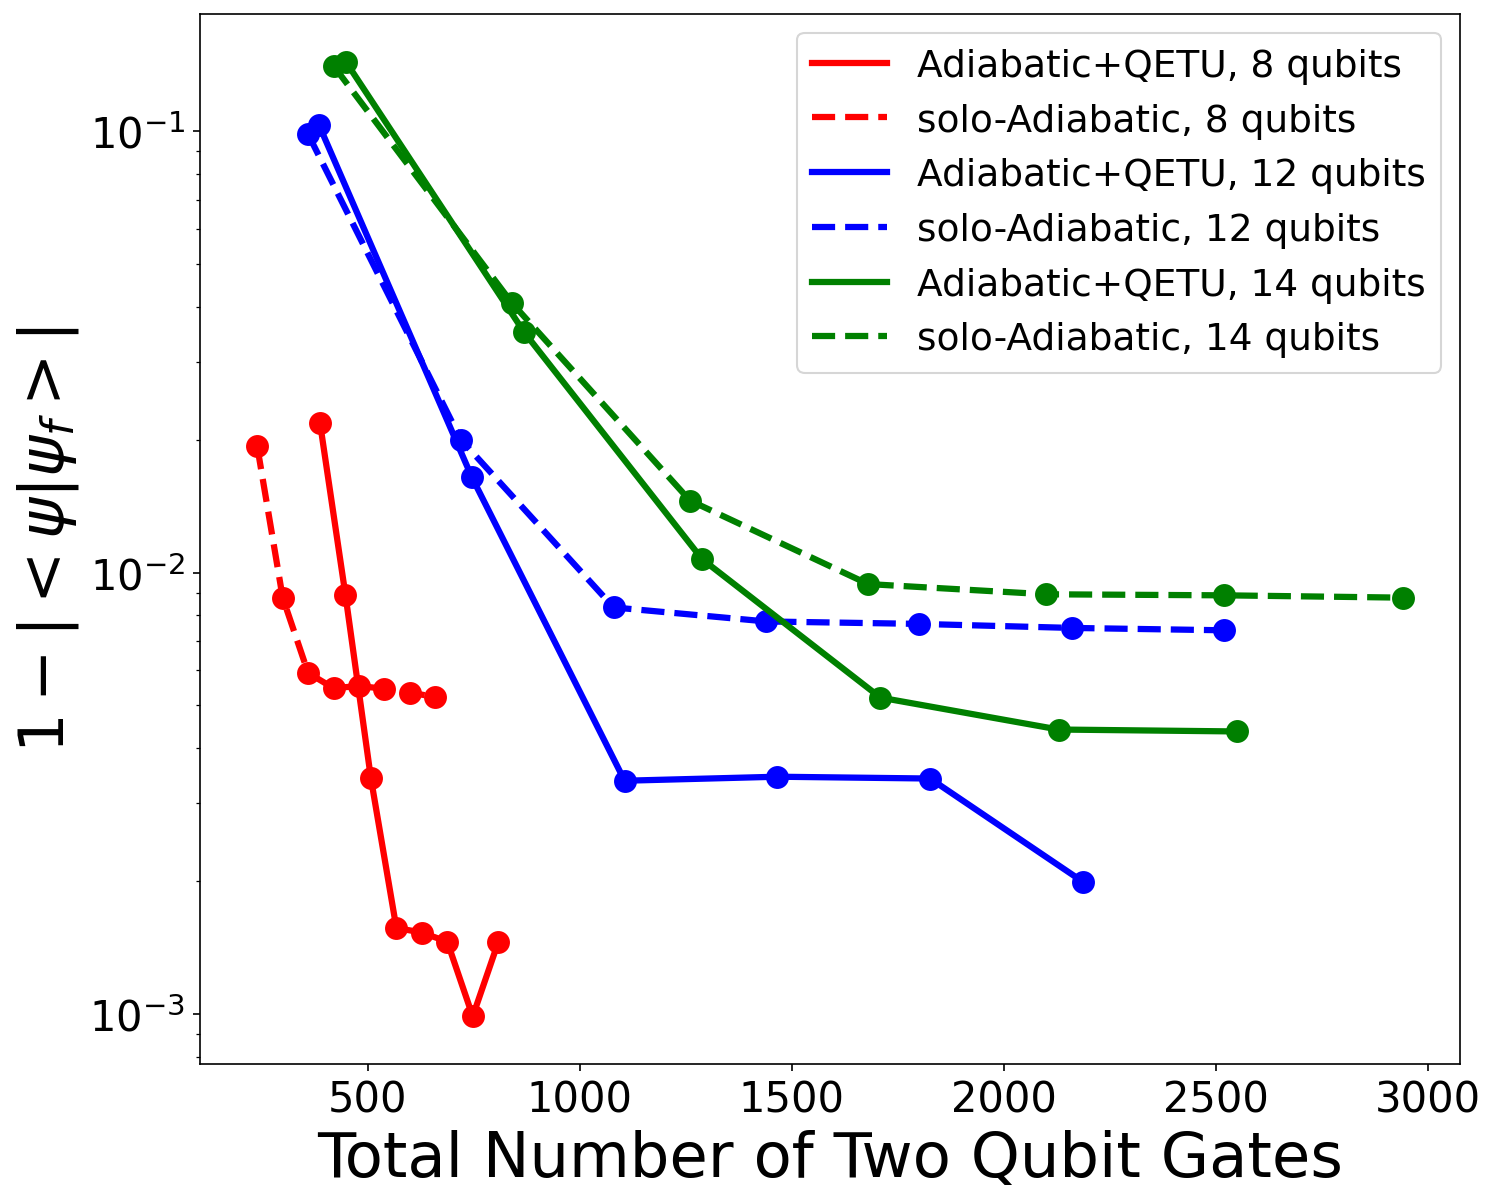

In [21]:
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8, wspace=0.5, hspace=0.2)
plt.rcParams["figure.figsize"] = (12, 10)
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 150

colors = ['red', 'blue', 'green', 'orange']

l = 0
for L in [8, 12, 14]:
    plt.plot(cxs[L], [1-fid for fid in fids[L]], label=f'Adiabatic+QETU, {L} qubits', color=colors[l],linewidth=3.0)  
    plt.scatter(cxs[L], [1-fid for fid in fids[L]], color=colors[l], s=100)
    
    plt.plot(cxs_A[L], [1-fid for fid in fids_A[L]], label=f'solo-Adiabatic, {L} qubits', ls='--', color=colors[l],linewidth=3.0)  
    plt.scatter(cxs_A[L], [1-fid for fid in fids_A[L]], color=colors[l], s=100)    
    l += 1
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Total Number of Two Qubit Gates', size=30)
plt.ylabel(r'$1-|<\psi|\psi_f>|$', size=30)
plt.legend(prop={'size': 18})